In [1]:
import os
import gzip

import numpy as np
import pandas as pd
from PIL import Image

import time
from tqdm import tqdm_notebook
# from tqdm import trange

import keras
from keras import backend as K
from keras.models import Model, load_model
from keras.optimizers import SGD, Adam
from keras.layers import Input, Dense, Flatten, Dropout, Conv2D, GlobalAveragePooling2D # MaxPooling2D, UpSampling2D, concatenate, Cropping2D, Reshape, BatchNormalization
from keras.utils import HDF5Matrix
#from keras.utils.data_utils import get_file
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array
from keras.utils import to_categorical

from keras.applications.mobilenet import preprocess_input

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:

from keras.optimizers import SGD, Adam
from keras.metrics import categorical_crossentropy

from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet import preprocess_input

import os
import time
from IPython import display


In [3]:
from preprocess import DataGenerator

In [4]:
data_dir = './data/'

In [5]:
pc_train_x_h5 = gzip.open(data_dir + 'camelyonpatch_level_2_split_train_x.h5.gz', 'rb')
pc_train_y_h5 = gzip.open(data_dir + 'camelyonpatch_level_2_split_train_y.h5.gz', 'rb')
pc_valid_y_h5 = gzip.open(data_dir + 'camelyonpatch_level_2_split_valid_y.h5.gz', 'rb')
pc_valid_x_h5 = gzip.open(data_dir + 'camelyonpatch_level_2_split_valid_x.h5.gz', 'rb')
pc_test_x_h5 = gzip.open(data_dir + 'camelyonpatch_level_2_split_test_x.h5.gz', 'rb')
pc_test_y_h5 = gzip.open(data_dir + 'camelyonpatch_level_2_split_test_y.h5.gz', 'rb')
meta_train = pd.read_csv('./data/camelyonpatch_level_2_split_train_meta.csv')
meta_valid = pd.read_csv('./data/camelyonpatch_level_2_split_valid_meta.csv')
meta_test = pd.read_csv('./data/camelyonpatch_level_2_split_test_meta.csv')

In [6]:
x_train = HDF5Matrix(pc_train_x_h5, 'x')
y_train = HDF5Matrix(pc_train_y_h5, 'y')
x_valid = HDF5Matrix(pc_valid_x_h5, 'x')
y_valid = HDF5Matrix(pc_valid_y_h5, 'y')
x_test = HDF5Matrix(pc_test_x_h5, 'x')
y_test = HDF5Matrix(pc_test_y_h5, 'y')

In [7]:
limit_data = True
limit = 10000

In [8]:
if limit_data: 
    x_train = x_train[:limit]
    y_train = y_train[:limit]
    x_valid = x_valid[:limit]
    y_valid = y_valid[:limit]

### Data Generator

In [9]:
# indexes
train_id = np.arange(len(x_train))
val_id = np.arange(len(x_valid))

# create a useful dictionary structures
partition = {}
partition['train'] = train_id
partition['validation'] = val_id
    
train_labels = {str(i) : y_train[i].flatten()[0] for i in train_id}
val_labels = {str(i) : y_valid[i].flatten()[0] for i in val_id}

In [10]:
vgg19 = keras.applications.vgg19.VGG19(weights='imagenet', include_top=False, input_shape=(224,224,3))

W0504 18:51:51.030324 140499910697088 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0504 18:51:51.037978 140499910697088 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0504 18:51:51.039440 140499910697088 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0504 18:51:51.053903 140499910697088 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/keras/backend/tensorflow_b

In [11]:

x = vgg19.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
#x = Dropout(0.5)(x)
y = Dense(2, activation='softmax')(x) # sigmoid instead of softmax to have independent probabilities

model = Model(inputs=vgg19.input, outputs=y)

# Train only the top layer
for layer in vgg19.layers:
    layer.trainable = False

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [13]:
optimizer = Adam(lr=0.01, beta_1=0.9, beta_2=0.999,)

In [14]:
model.compile(optimizer, 
              loss='categorical_crossentropy', 
              metrics=['acc'])

W0504 18:51:51.861590 140499910697088 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [15]:
def train_network(network, training_generator, validation_generator, n_epoch, network_filepath):
    
    # lists where we will be storing values during training, for visualization purposes
    tra_losses = [] # list for training loss
    tra_accs = [] # list for training accuracy
    val_losses = [] # list for validation loss
    val_accs = [] # list for validation accuracy

    # we want to save the parameters that give the best performance on the validation set
    # therefore, we store the best validation accuracy, and save the parameters to disk
    best_validation_accuracy = 0 # best validation accuracy

    for epoch in range(n_epoch):
        st = time.time()

        # Train your network
        results = network.fit_generator(training_generator)

        # Get training loss and accuracy
        training_loss = results.history['loss']
        training_accuracy = results.history['acc']

        # Add to list
        tra_losses.append(training_loss)
        tra_accs.append(training_accuracy)

        # Evaluate performance (loss and accuracy) on validation set
        scores = network.evaluate_generator(validation_generator)     
        validation_loss = scores[0]
        validation_accuracy = scores[1]

        # Add to list
        val_losses.append(validation_loss)
        val_accs.append(validation_accuracy)

        # (Possibly) update best validation accuracy and save the network
        if validation_accuracy > best_validation_accuracy:
            best_validation_accuracy = validation_accuracy
            network.save(network_filepath)

        # Visualization of the learning curves
        fig = plt.figure(figsize=(10, 5))
        tra_loss_plt, = plt.plot(range(len(tra_losses)), tra_losses, 'b')
        tra_accs_plt, = plt.plot(range(len(tra_accs)), tra_accs, 'c')
        val_loss_plt, = plt.plot(range(len(val_losses)), val_losses, 'g')
        val_acc_plt, = plt.plot(range(len(val_accs)), val_accs, 'r')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend([tra_loss_plt, tra_accs_plt, val_loss_plt, val_acc_plt], 
                  ['training loss', 'training accuracy', 'validation loss', 'validation accuracy'],
                  loc='center left', bbox_to_anchor=(1, 0.5))
        plt.title('Best validation accuracy = {:.2f}%'.format(100. * best_validation_accuracy))
        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(.2)

In [16]:
# Define batch size.
batch_size = 32
n_epoch = 5

# Parameters for generators
params = {
    'dim': (224, 224),
    'batch_size': batch_size,
    'n_classes': 2,
    'shuffle': True
}

# Generators
training_generator = DataGenerator.DataGenerator(partition['train'], x_train, train_labels, **params)
validation_generator = DataGenerator.DataGenerator(partition['validation'], x_valid, val_labels, **params)

In [18]:
# directory to save the best model

file_dir = '../Model'
if os.path.exists(file_dir):
    network_filepath = os.path.join(file_dir, 'best_model.h5')
else:
    os.mkdir(file_dir)
    network_filepath = os.path.join(file_dir, 'best_model.h5')

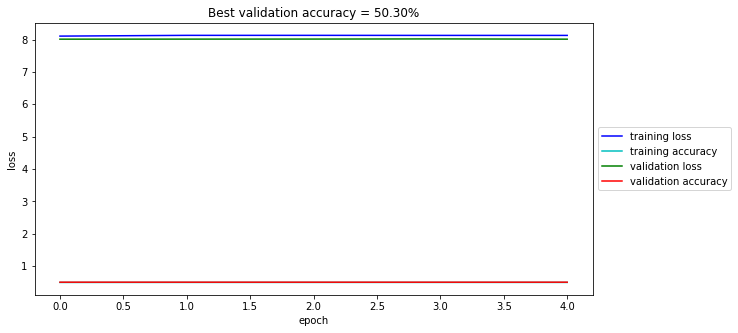

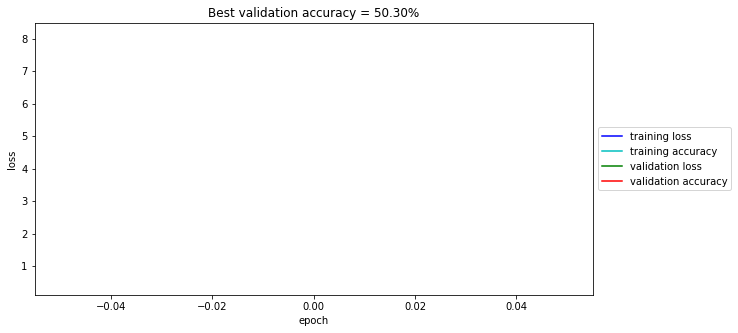

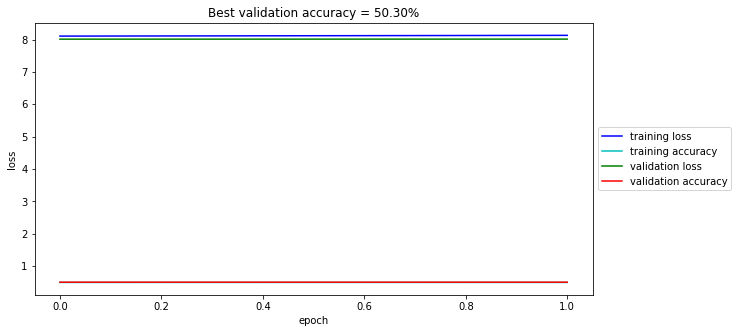

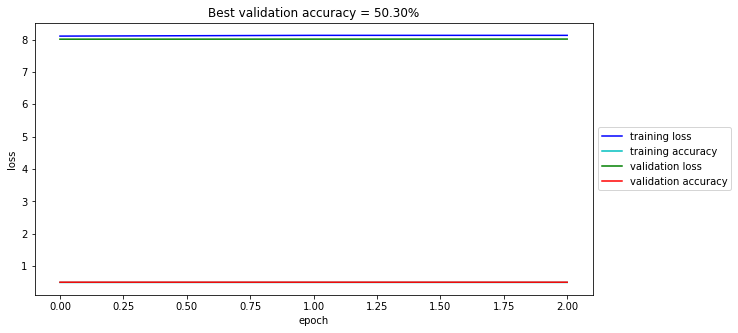

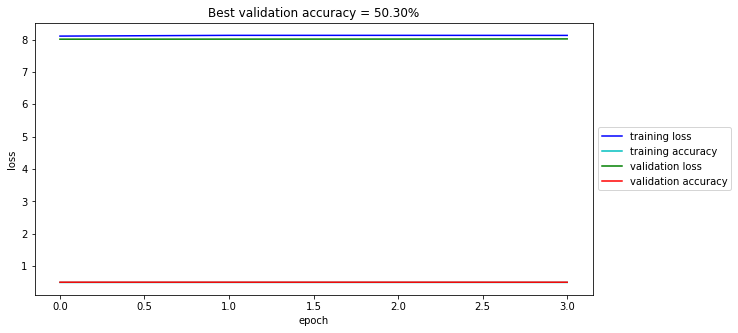

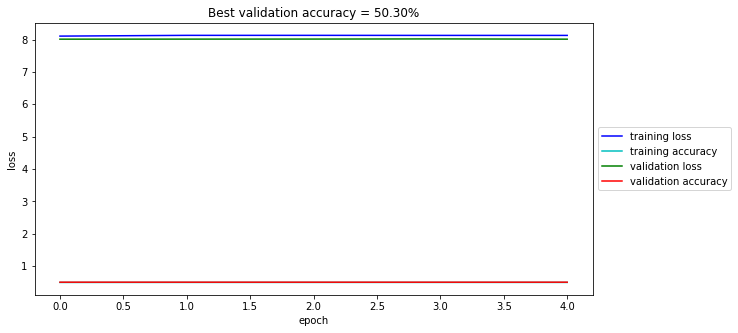

In [19]:
# Train the model 

train_network(model, training_generator, validation_generator, n_epoch, network_filepath)